In [3]:
# some standard imports
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad as compute_grad   
from autograd.misc.flatten import flatten_func
from mlrefined_libraries import math_optimization_library as optlib
from datetime import datetime 
from mlrefined_libraries import multilayer_perceptron_library as network_lib
import copy

static_plotter = optlib.static_plotter.Visualizer();

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

# Gradient descent

In [4]:
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
from autograd import value_and_grad 

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha_choice,max_its,w):
    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(w)
        cost_history.append(cost_eval)

        # take gradient descent step
        w = w - alpha*grad_eval
            
    # collect final weights
    weight_history.append(w)
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    cost_history.append(g(w))  
    return weight_history,cost_history

# Zero order coordinate descent

In [6]:
# zero order coordinate search
def coordinate_descent_zero_order(g,alpha_choice,max_its,w):  
    # run coordinate search
    N = np.size(w)
    weight_history = []         # container for weight history
    cost_history = []           # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):        
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # random shuffle of coordinates
        c = np.random.permutation(N)
        
        # forming the dirction matrix out of the loop
        DIRECTION = np.eye(N)
        cost = g(w)
        
        # loop over each coordinate direction
        for n in range(N):
            #direction = np.zeros((N,1))
            #direction[c[n]] = 1
            direction = DIRECTION[:,[c[n]]]
     
            # record weights and cost evaluation
            weight_history.append(w)
            cost_history.append(cost)

            # evaluate all candidates
            evals =  [g(w + alpha*direction)]
            evals.append(g(w - alpha*direction))
            evals = np.array(evals)

            # if we find a real descent direction take the step in its direction
            ind = np.argmin(evals)
            if evals[ind] < cost_history[-1]:
                # take step
                w = w + ((-1)**(ind))*alpha*direction
                cost = evals[ind]
        
    # record weights and cost evaluation
    weight_history.append(w)
    cost_history.append(g(w))
    return weight_history,cost_history

# General comparison wrapper

In [22]:
def compare_algos(g,w,its,grad_alpha,coord_alpha):
    #### flatten the input and input function ###
    g_flat, unflatten, w_flat = flatten_func(g, w)
    w_flat.shape = (np.size(w_flat),1)
    w_flat2 = copy.deepcopy(w_flat)

    ############ run standard gradient descent ############
    alpha_choice = grad_alpha; max_its = np.size(w_flat)*its;

    start_time = datetime.now() 

    weight_history_1,cost_history_1 = gradient_descent(g_flat,alpha_choice,max_its,w_flat)

    time_elapsed = datetime.now() - start_time 
    print('Time elapsed for gradient descent run (hh:mm:ss.ms) {}'.format(time_elapsed))

    ############ run zero-order coordinate descent ############
    alpha_choice = coord_alpha; max_its = its; 

    start_time = datetime.now() 

    weight_history_2, cost_history_2 = coordinate_descent_zero_order(g_flat,alpha_choice,max_its,w_flat2)

    time_elapsed = datetime.now() - start_time 
    print('Time elapsed for coordinate descent run (hh:mm:ss.ms) {}'.format(time_elapsed))
    
    return cost_history_1,cost_history_2

# two-class classification - face detection dataset

## load a face detection dataset

A dataset of size $P = 10,000$ face detection dataset (about 5K faces and non-face images).

In [72]:
# load in large-ish dataset
datapath = '../../mlrefined_datasets/convnet_datasets/feat_face_data.csv'
data = np.loadtxt(datapath,delimiter = ',')
x = data[:,:-1]
y = data[:,-1:]

In [73]:
# load in data - for this one split up training and testing
ind = np.random.permutation(len(data))
data_train = data[ind[:-1],:]
data_test = data[ind[-2000:],:]

x = data_train[:,:-1]
y = data_train[:,-1:]
num_pts = len(y)

### Compare algorithms

In [74]:
# the softmax cost function
def softmax(w):
    cost  = np.sum(np.log(1 + np.exp((-y)*(w[0] + np.dot(x,w[1:])))))
    return cost

Time elapsed for gradient descent run (hh:mm:ss.ms) 0:00:41.331312
Time elapsed for coordinate descent run (hh:mm:ss.ms) 0:00:42.320066


<IPython.core.display.Javascript object>


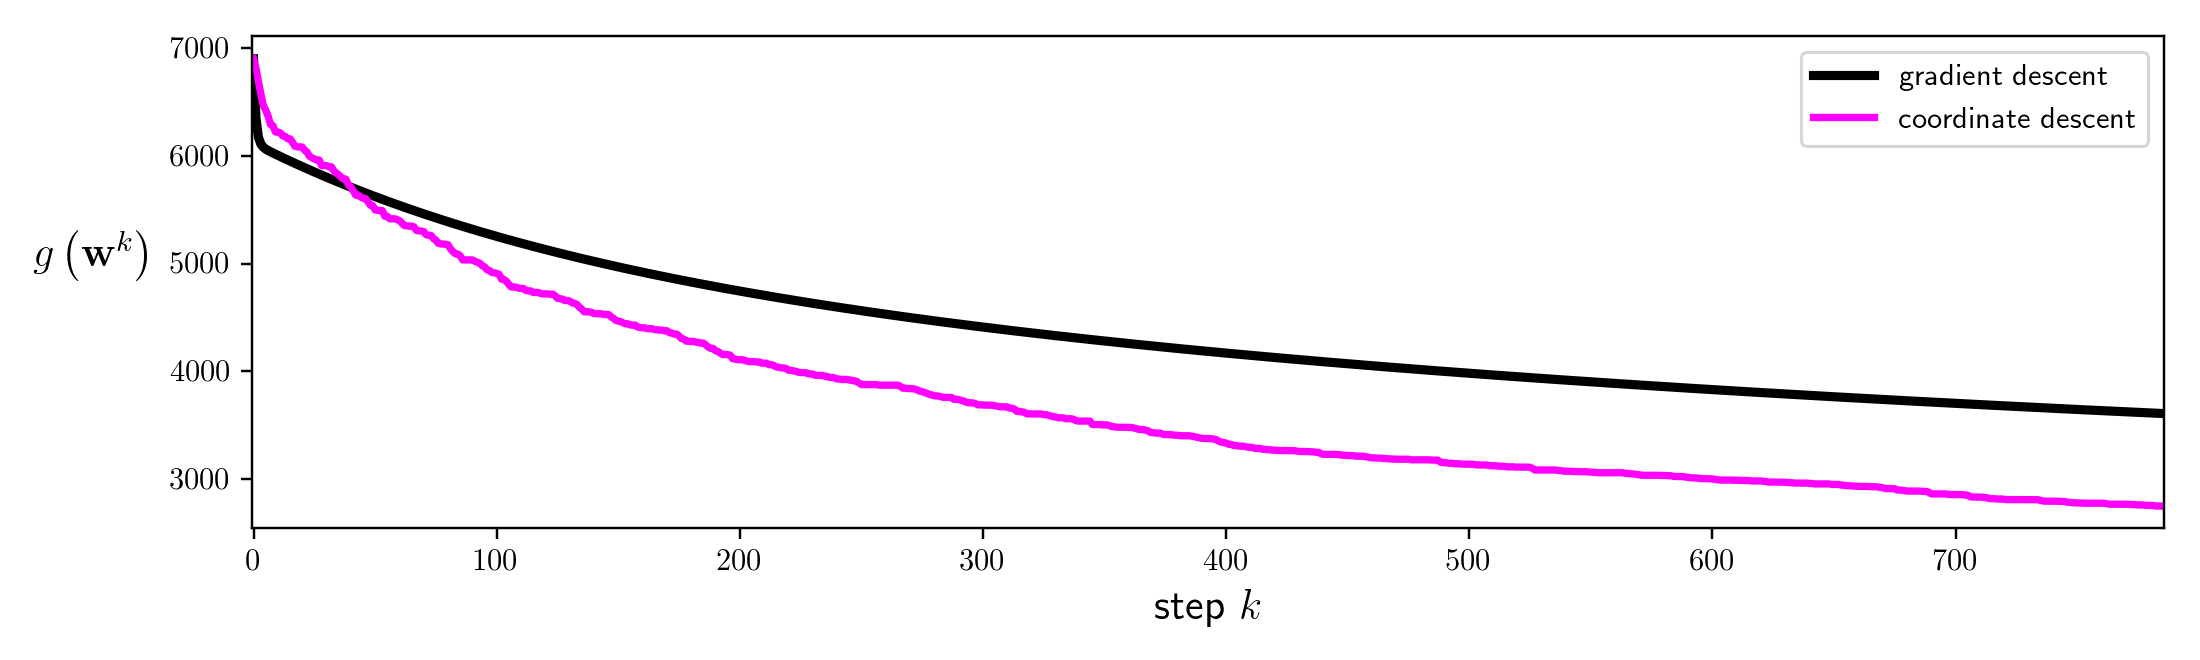

In [75]:
# define 
grad_alpha = 10**(-4)
coord_alpha = 2
g = softmax
its = 1
scale = 0.1
w = scale*np.random.randn(np.shape(x)[1]+1,1)
cost_history_1,cost_history_2 = compare_algos(g,w,its,grad_alpha,coord_alpha)

############ compare cost function histories for each run ############
static_plotter.plot_cost_histories([cost_history_1,cost_history_2],start = 0,points = False,labels = ['gradient descent','coordinate descent'])

# Multilayer perceptron

## maxout network setup

In [9]:
# create initial weights for arbitrary feedforward network
def initialize_network_weights(layer_sizes,scale):
    # container for entire weight tensor
    weights = []
    
    # loop over desired layer sizes and create appropriately sized initial 
    # weight matrix for each layer
    for k in range(len(layer_sizes)-1):
        # get layer sizes for current weight matrix
        U_k = layer_sizes[k]
        U_k_plus_1 = layer_sizes[k+1]

        # make weight matrix
        weight1 = scale*np.random.randn(U_k + 1,U_k_plus_1)
        
        # add second matrix for inner weights
        if k < len(layer_sizes)-2:
            weight2 = scale*np.random.randn(U_k + 1,U_k_plus_1)
            weights.append([weight1,weight2])
        else:
            weights.append(weight1)

    # re-express weights so that w_init[0] = omega_inner contains all 
    # internal weight matrices, and w_init = w contains weights of 
    # final linear combination in predict function
    w_init = [weights[:-1],weights[-1]]
    
    return w_init

In [10]:
# our normalization function
def normalize(data,data_mean,data_std):
    normalized_data = (data - data_mean)/data_std
    return normalized_data

In [11]:
def activation(t1,t2):
    # maxout activation
    f = np.maximum(t1,t2)
    return f

In [12]:
def compute_features_normalized(x, inner_weights):
    # pad data with ones to deal with bias
    o = np.ones((np.shape(x)[0],1))
    a_padded = np.concatenate((o,x),axis = 1)
        
    # loop through weights and update each layer of the network
    for W1,W2 in inner_weights:                                  ###### THIS LINE WAS CHANGED FROM THE ORIGINAL #####
        # output of layer activation  
        a = activation(np.dot(a_padded,W1),np.dot(a_padded,W2))  ###### THIS LINE WAS CHANGED FROM THE ORIGINAL #####
                
        ### normalize output of activation
        # compute the mean and standard deviation of the activation output distributions
        a_means = np.mean(a,axis = 0)
        a_stds = np.std(a,axis = 0)
        
        # normalize the activation outputs
        a_normed = normalize(a,a_means,a_stds)
            
        # pad with ones for bias
        o = np.ones((np.shape(a_normed)[0],1))
        a_padded = np.concatenate((o,a_normed),axis = 1)
    
    return a_padded

In [13]:
# our predict function 
def predict_normalized(x,w):     
    # feature trasnsformations
    f = compute_features_normalized(x,w[0])
    
    # compute linear model
    vals = np.dot(f,w[1])
    return vals

## Test run

In [77]:
csvname = '../../mlrefined_datasets/superlearn_datasets/noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:,:-1]
y = data[:,-1:]

# compute the mean and standard deviation of our input, then normalize the input
x_means = np.mean(x,axis = 0)
x_stds = np.std(x,axis = 0)

# normalize the input data
x_normed = normalize(x,x_means,x_stds)

# least squares
least_squares_normalized = lambda w: np.sum((predict_normalized(x_normed,w) - y)**2)

In [78]:
# A 5 layer network architecture
N = np.shape(x_normed)[1]
M = np.shape(y)[1]
U_1 = 10                # number of units in layer 1
U_2 = 10                # number of units in layer 2
U_3 = 10                # number of units in layer 3
U_4 = 10                # number of units in layer 4
U_5 = 10                # number of units in layer 5

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,U_4,U_5,M]

# generate initial weights for our network
w = initialize_network_weights(layer_sizes,scale = 0.5)

In [79]:
# define 
grad_alpha = 10**(-3)
coord_alpha = 'diminishing'
g = least_squares_normalized
its = 3
cost_history_1,cost_history_2 = compare_algos(g,w,its,grad_alpha,coord_alpha)

Time elapsed for gradient descent run (hh:mm:ss.ms) 0:00:20.420435
Time elapsed for coordinate descent run (hh:mm:ss.ms) 0:00:08.873753


<IPython.core.display.Javascript object>


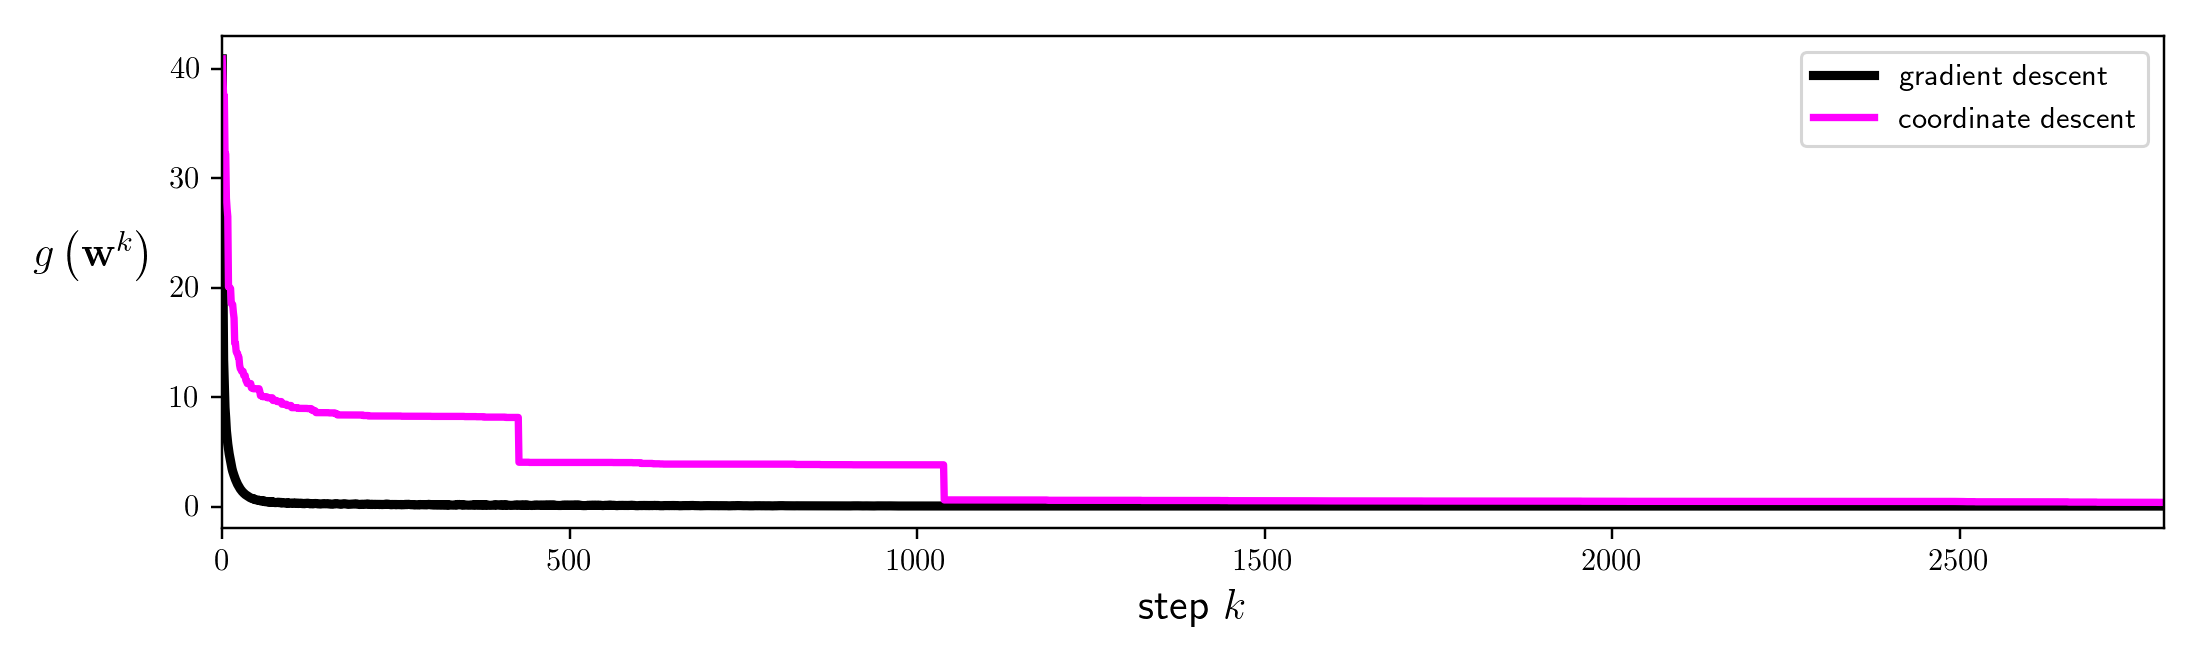

In [81]:
############# compare cost function histories for each run ############
static_plotter.plot_cost_histories([cost_history_1,cost_history_2],start = 0,points = False,labels = ['gradient descent','coordinate descent'])

# Multiclass dataset

## load in MNIST dataset